In [6]:
import numpy as np 
import pandas as pd 
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [8]:
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
file_path = "C:/Users/LENOVO/Desktop/ab_data.csv"
df = pd.read_csv(file_path)

In [12]:
print(df.shape)
print(len(df.index))

(294478, 5)
294478


In [13]:
df.user_id.nunique()

290584

In [14]:
len(df.query('converted==1'))/len(df.index)

0.11965919355605512

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [17]:
df2=df

In [18]:
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]

In [19]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

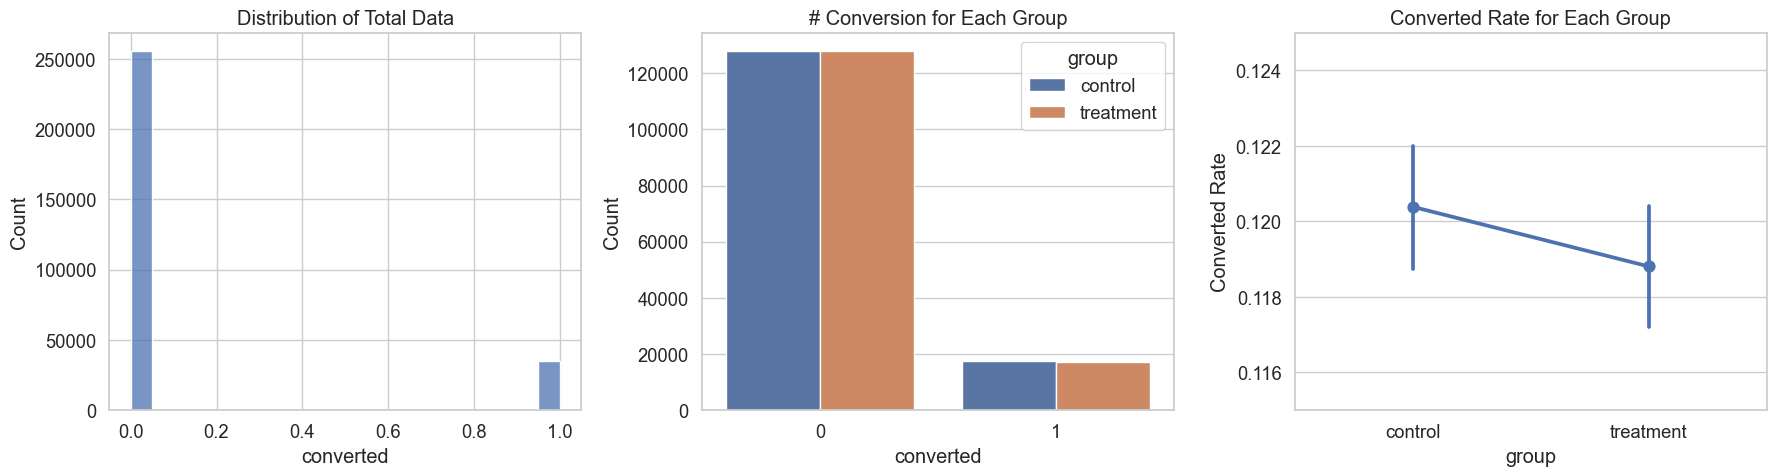

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ① histplot
sns.histplot(x="converted", data=df2, ax=axes[0])
axes[0].set_title("Distribution of Total Data")
axes[0].set_ylabel("Count")

# ② countplot
sns.countplot(x="converted", data=df2, hue="group", ax=axes[1])
axes[1].set_title("# Conversion for Each Group")
axes[1].set_ylabel("Count")

# ③ pointplot
sns.pointplot(x="group", y="converted", data=df2, ax=axes[2])
axes[2].set_ylim([0.115, 0.125])  # 시각적으로 미세한 차이 강조
axes[2].set_title("Converted Rate for Each Group")
axes[2].set_ylabel("Converted Rate")

plt.tight_layout()
plt.show()

In [21]:
df2.user_id.nunique()

290584

In [22]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

In [23]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [24]:
# Now we remove duplicate rows
df2 = df2.drop_duplicates()
# Check agin if duplicated values are deleted or not
sum(df2.duplicated())

0

In [25]:
df2['converted'].mean()

0.11959667567149027

In [26]:
# The probability of an individual converting given that an individual was in the control group
control_group = len(df2.query('group=="control" and converted==1'))/len(df2.query('group=="control"'))
control_group

0.1203863045004612

In [27]:
# The probability of an individual converting given that an individual was in the treatment group
treatment_group = len(df2.query('group=="treatment" and converted==1'))/len(df2.query('group=="treatment"'))
treatment_group

0.11880724790277405

In [28]:
# The probability of individual received new page
len(df2.query('landing_page=="new_page"'))/len(df2.index)

0.5000636646764286

## A/B Test

In [29]:
p_new = len(df2.query( 'converted==1'))/len(df2.index)
p_new

0.11959667567149027

In [30]:
p_old = len(df2.query('converted==1'))/len(df2.index)
p_old

0.11959667567149027

In [31]:
p=np.mean([p_old,p_new])
print(p)
# difference of p_new and p_old
p_diff=p_new-p_old

0.11959667567149027


In [32]:
n_new = len(df2.query('landing_page=="new_page"'))
#print n_new
n_new

145311

In [33]:
n_old = len(df2.query('landing_page=="old_page"'))
#print n_old
n_old

145274

In [34]:
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

In [35]:
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

In [36]:
obs_diff= new_page_converted.mean() - old_page_converted.mean()# differences computed in from p_new and p_old
obs_diff

0.0005603884564205908

In [37]:
# Create sampling distribution for difference in p_new-p_old simulated values
# with boostrapping
p_diffs = []
for i in range(10000):
    
    # 1st parameter dictates the choices you want.  In this case [1, 0]
    p_new1 = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
    p_old1 = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
    p_new2 = p_new1.mean()
    p_old2 = p_old1.mean()
    p_diffs.append(p_new2-p_old2)
#_p_diffs = np.array(_p_diffs)

Text(0, 0.5, 'Count')

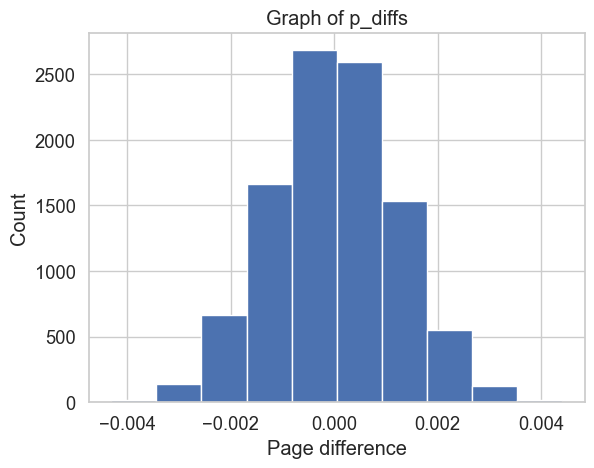

In [38]:
p_diffs=np.array(p_diffs)
#histogram of p_diff
plt.hist(p_diffs)
plt.title('Graph of p_diffs')#title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

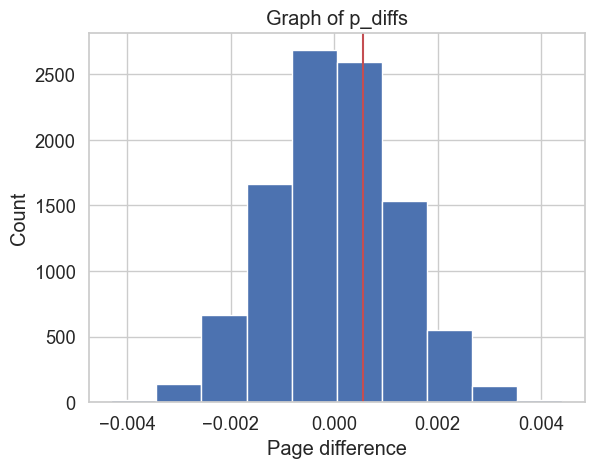

In [39]:
#histogram of p_diff
plt.hist(p_diffs);

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= obs_diff, color='r');

In [40]:
var1 = df2[df2['landing_page'] == 'new_page']
var1=var1['converted'].mean()
var2 = df2[df2['landing_page'] == 'old_page']
var2 = var2['converted'].mean()
actual_diff = var1-var2
count = 0
for i in p_diffs:
    if i> actual_diff:
        count = count+1
        
print (count/(len(p_diffs)))

0.9012


In [41]:
import statsmodels.api as sm

convert_old = len(df2.query('converted==1 and landing_page=="old_page"')) #rows converted with old_page
convert_new = len(df2.query('converted==1 and landing_page=="new_page"')) #rows converted with new_page
n_old = len(df2.query('landing_page=="old_page"')) #rows_associated with old_page
n_new = len(df2.query('landing_page=="new_page"')) #rows associated with new_page
n_new

145311

In [43]:
#Computing z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

1.3116075339133115 0.905173705140591


In [44]:
norm.cdf(z_score)

0.905173705140591

In [45]:
norm.ppf(1-(0.05))

1.6448536269514722

## Logistic Regression

In [46]:
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'].astype(int)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [47]:
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 Jun 2025   Pseudo R-squ.:               8.085e-06
Time:                        17:32:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [49]:
file_path = "C:/Users/LENOVO/Desktop/countries.csv"
countries_df = pd.read_csv(file_path)
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [50]:
df_new["country"].value_counts()

country
US    203620
UK     72466
CA     14499
Name: count, dtype: int64

In [51]:
df_new.groupby(["country"])["converted"].mean()

country
CA    0.115318
UK    0.120594
US    0.119546
Name: converted, dtype: float64

In [52]:
df_new.groupby(["country","group"])["converted"].mean()

country  group    
CA       control      0.118783
         treatment    0.111902
UK       control      0.120022
         treatment    0.121171
US       control      0.120630
         treatment    0.118464
Name: converted, dtype: float64

In [60]:
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country']).astype(int)

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [61]:
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Jun 2025   Pseudo R-squ.:               2.324e-05
Time:                        17:37:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

In [63]:
df_new['interaction_UK'] = df_new["UK"] *df_new["ab_page"]
df_new['interaction_CA'] = df_new["CA"] *df_new["ab_page"]
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','interaction_UK','CA','interaction_CA']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Tue, 24 Jun 2025   Pseudo R-squ.:               3.483e-05
Time:                        17:37:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1918
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page           -0.0206      0.014     -1.506      0.132      -0.047       0.006
UK                -0.0057      0.019     -0.306      0.760      -0.043       0.031
interaction_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
CA                -0.0175      0.038     -0.465      0.642      -0.091       0.056
interaction_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==================================================================================
"""